In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 30)
        self.fc3 = nn.Linear(30, 10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def forward_eval(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

batch_size = 64

# Load CIFAR-10 dataset with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Calculate the number of images in the train, validation, and test sets
total_images = len(trainset)
train_split = int(0.9 * total_images)
valid_split = total_images - train_split

# Create train and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_split, valid_split])

# Create data loaders for train, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Print dataset information
total_images += len(testset)
print(f'Number of total images: {total_images}')
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)} ")
print(f"Number of testing images: {len(testset)} ")

# Get the shape of an image
sample_image, _ = train_dataset[0]
image_shape = sample_image.shape
print(f"Image shape: {image_shape}")

Files already downloaded and verified
Files already downloaded and verified
Number of total images: 60000
Number of training images: 45000
Number of validation images: 5000 
Number of testing images: 10000 
Image shape: torch.Size([3, 32, 32])


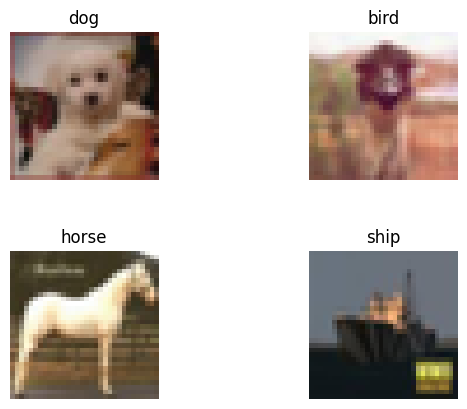

In [4]:
# Function to show images and labels in a 2x2 plot
def show_images_labels(images, labels, title_labels, classes):
    images = images / 2 + 0.5     # unnormalize
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad=3.0)

    for i in range(4):
        ax = axs[i // 2, i % 2]
        ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')

# Get some random training images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the 2x2 plot with labels as titles
show_images_labels(images, labels, classes, classes)

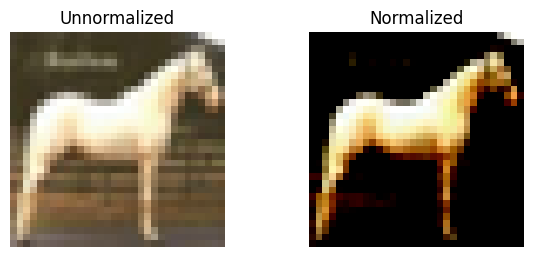

In [5]:
def show_normalized_image(image):
    # Unnormalize the image
    unnormalized_image = image / 2 + 0.5
    npimg_unnormalized = unnormalized_image.numpy()

    # Show original and unnormalized image
    fig, axs = plt.subplots(1, 2)
    fig.tight_layout(pad=3.0)

    axs[0].imshow(np.transpose(npimg_unnormalized, (1, 2, 0)))
    axs[0].set_title("Unnormalized")
    axs[0].axis('off')

    axs[1].imshow(np.transpose(image, (1, 2, 0)))
    axs[1].set_title("Normalized")
    axs[1].axis('off')

# Show an image before and after normalization
show_normalized_image(images[2])

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [8]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

# Initialize variables for early stopping
best_valid_loss = float('inf')
best_epoch = -1
best_train_loss = float('inf')
best_train_acc = 0
best_valid_acc = 0

# Training loop
epochs = 100
patience = 15  # Number of epochs with no improvement before stopping
count = 0  # Counter for patience

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / i)
    train_accuracy.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct_valid = 0
    total_valid = 0
    valid_loss = 0

    with torch.no_grad():
        for data in validloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model.forward_eval(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_losses.append(valid_loss / len(validloader))
    valid_accuracy.append(100 * correct_valid / total_valid)

    print(f'Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}% - Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracy[-1]:.2f}%')

    # Check for early stopping
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        best_epoch = epoch
        best_train_loss = train_losses[-1]
        best_train_acc = train_accuracy[-1]
        best_valid_acc = valid_accuracy[-1]
        count = 0
        # Save the best model checkpoint
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': best_train_loss,
            'train_acc': best_train_acc,
            'valid_loss': best_valid_loss,
            'valid_acc': best_valid_acc
        }, 'best_model_checkpoint.pth')
    else:
        count += 1

    if count >= patience:
        print(f'Early stopping after {epoch + 1} epochs with no improvement.')
        break

# Load the best model checkpoint at the end of training
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_epoch = checkpoint['epoch']
best_train_loss = checkpoint['train_loss']
best_train_acc = checkpoint['train_acc']
best_valid_loss = checkpoint['valid_loss']
best_valid_acc = checkpoint['valid_acc']

Epoch [1/100] - Train Loss: 1.7147, Train Acc: 36.66% - Valid Loss: 1.3582, Valid Acc: 50.54%
Epoch [2/100] - Train Loss: 1.4094, Train Acc: 49.69% - Valid Loss: 1.2642, Valid Acc: 54.22%
Epoch [3/100] - Train Loss: 1.2946, Train Acc: 54.25% - Valid Loss: 1.1622, Valid Acc: 59.92%
Epoch [4/100] - Train Loss: 1.2184, Train Acc: 57.19% - Valid Loss: 1.0828, Valid Acc: 62.52%
Epoch [5/100] - Train Loss: 1.1564, Train Acc: 59.76% - Valid Loss: 1.0357, Valid Acc: 63.72%
Epoch [6/100] - Train Loss: 1.1091, Train Acc: 61.44% - Valid Loss: 1.0213, Valid Acc: 64.62%
Epoch [7/100] - Train Loss: 1.0750, Train Acc: 62.85% - Valid Loss: 0.9455, Valid Acc: 67.32%
Epoch [8/100] - Train Loss: 1.0436, Train Acc: 63.98% - Valid Loss: 0.9340, Valid Acc: 68.08%
Epoch [9/100] - Train Loss: 1.0190, Train Acc: 64.78% - Valid Loss: 0.9136, Valid Acc: 68.32%
Epoch [10/100] - Train Loss: 1.0000, Train Acc: 65.76% - Valid Loss: 0.9295, Valid Acc: 69.18%
Epoch [11/100] - Train Loss: 0.9752, Train Acc: 66.32% - Va

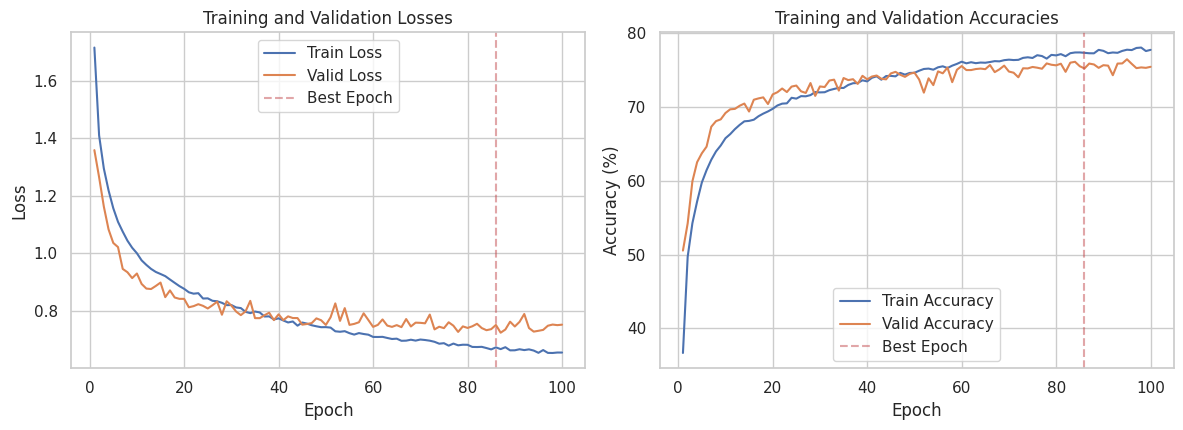

In [9]:
data = {'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Valid Loss': valid_losses,
        'Train Accuracy': train_accuracy,
        'Valid Accuracy': valid_accuracy}
df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss')
sns.lineplot(x='Epoch', y='Valid Loss', data=df, label='Valid Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(2, 2, 2)
sns.lineplot(x='Epoch', y='Train Accuracy', data=df, label='Train Accuracy')
sns.lineplot(x='Epoch', y='Valid Accuracy', data=df, label='Valid Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No gradients needed for inference
model.eval()
model.to('cpu')
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model.forward_eval(images)
        _, predictions = torch.max(outputs, 1)

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy for each class
class_accuracies = {classname: (correct_count / total_pred[classname]) * 100 for classname, correct_count in correct_pred.items()}

# Print accuracy for each class
tot_acc = 0
for classname, accuracy in class_accuracies.items():
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    tot_acc += accuracy
print('---------------------------------------')
print(f'Overall network accuracy: {round(tot_acc / len(classes), 2)} %')

Accuracy for class: plane is 80.8 %
Accuracy for class: car   is 88.3 %
Accuracy for class: bird  is 68.3 %
Accuracy for class: cat   is 55.8 %
Accuracy for class: deer  is 68.7 %
Accuracy for class: dog   is 66.3 %
Accuracy for class: frog  is 79.1 %
Accuracy for class: horse is 83.6 %
Accuracy for class: ship  is 86.7 %
Accuracy for class: truck is 82.3 %
---------------------------------------
Overall network accuracy: 75.99 %


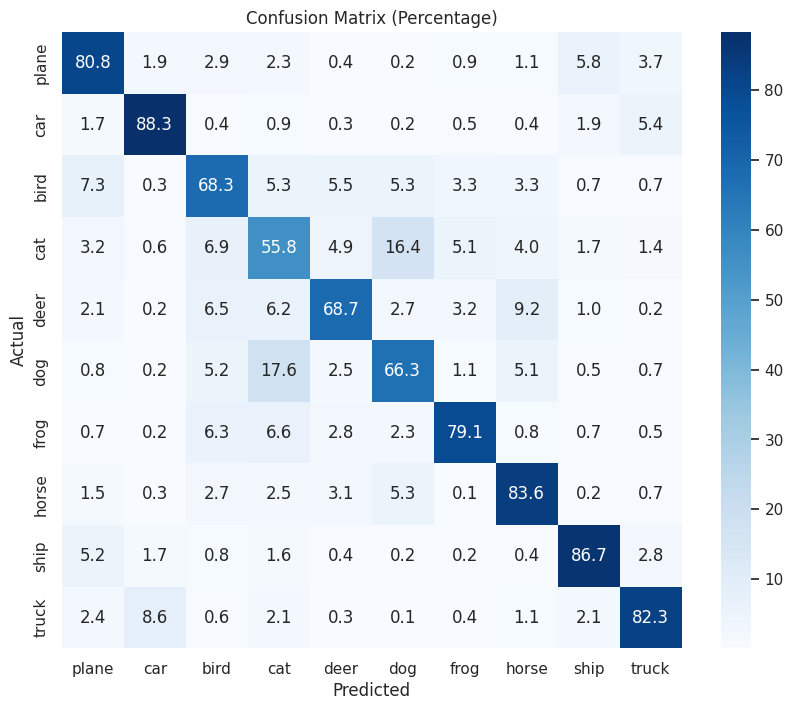

In [13]:
# Create a confusion matrix in percentage
cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(classes)))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
df_cm = pd.DataFrame(cm_percentage, index=classes, columns=classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.1f', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()